<b>Question2</b>

Vision Transformer: Analyzing Attention and Performance on CIFAR-10: Implement
a Vision Transformer on CIFAR-10, analyze its attention maps and performance, and experiment
with hyperparameters to evaluate their impact.

(a) Implement an Encoder only Vision Transformer (ViT) using PyTorch on the CIFAR-10
dataset, including key components such as patch embedding, positional embeddings, the
Transformer encoder with multi-head self-attention, and a classification head using the CLS
token. [10 marks]

(b) Set up the training procedure for your ViT model on the CIFAR-10 dataset, and analyze its
performance (e.g., accuracy, loss) to evaluate how well your model learns. [6 marks]

(c) Visualize and carefully analyze attention maps from different layers and attention heads of
your transformer to identify patterns and insights. Evaluate how effectively your ViT captures
global context and spatial relationships within images through attention maps. [8 marks]

(d) Experiment by varying hyper parameters such as patch size, number of transformer layers,
and attention heads to observe their impact on attention patterns and model performance.
Discuss your findings clearly with supporting visualizations and examples. [6 marks]


In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [37]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainload = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=True, num_workers=2)
testload = torch.utils.data.DataLoader(data_test, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [39]:
class EmbedImage(nn.Module):
    def __init__(self, img_h, img_w, patchsize, dim):
        super().__init__()
        self.npatches = (img_h * img_w) // (patchsize * patchsize)
        self.conv = nn.Conv2d(3, dim, patchsize, stride=patchsize)

    def forward(self, x):
        out = self.conv(x)  
        out = out.flatten(2).transpose(1, 2) 
        return out


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, dim, nheads):
        super().__init__()
        self.nheads = nheads
        self.dim = dim
        self.head_dim = dim // nheads        
        self.wq = nn.ModuleList([nn.Linear(dim, self.head_dim) for _ in range(nheads)])
        self.wk = nn.ModuleList([nn.Linear(dim, self.head_dim) for _ in range(nheads)])
        self.wv = nn.ModuleList([nn.Linear(dim, self.head_dim) for _ in range(nheads)])
        self.wo = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)
        self.attn_weights = None 

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        q = torch.stack([self.wq[i](x) for i in range(self.nheads)], dim=1)
        k = torch.stack([self.wk[i](x) for i in range(self.nheads)], dim=1)
        v = torch.stack([self.wv[i](x) for i in range(self.nheads)], dim=1)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        self.attn_weights = self.softmax(attn_scores) 
        
        attn_output = torch.matmul(self.attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.dim)
        out = self.wo(attn_output)
        return out

In [41]:
class EncoderBlock(nn.Module):
    def __init__(self, dim, nheads, dropout=0.1):
        super().__init__()
        self.attn = SelfAttention(dim, nheads)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 2*dim),
            nn.ReLU(),
            nn.Linear(2*dim, dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

In [42]:
class Transformer(nn.Module):
    def __init__(self, nlayers, nheads, img_h, img_w, patch_size, embeddim, outdim=10):
        super().__init__()
        self.embedder = EmbedImage(img_h, img_w, patch_size, embeddim)
        self.positions = nn.Parameter(torch.randn(1, (img_h * img_w) // (patch_size * patch_size) + 1, embeddim))
        self.norm = nn.LayerNorm(embeddim)
        self.classifier = nn.Linear(embeddim, outdim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embeddim))
        self.layers = nn.ModuleList([
            EncoderBlock(embeddim, nheads) for _ in range(nlayers)
        ]) 

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.embedder(x)  
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  
        x = torch.cat((cls_tokens, x), dim=1) 
        x = x + self.positions  
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x[:, 0])  
        x = self.classifier(x)
        return x

    def get_attention_maps(self):
        return [layer.attn.attn_weights for layer in self.layers]

In [ ]:
m2 = Transformer(3, 3, 32, 32, 8, 72, 10).to(device)

In [ ]:
optimizer = torch.optim.Adam(m2.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for batchx, batchy in train_loader:
            batchx, batchy = batchx.to(device), batchy.to(device)
            batchy = batchy.long()
            outputs = model(batchx)
            loss = criterion(outputs, batchy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batchx.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(batchy).sum().item()
            total += batchy.size(0)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/total:.4f}, Acc: {correct/total:.4f}')

In [9]:
train(m2, trainload, criterion, optimizer, epochs=150)

Epoch [1/150], Loss: 1.8778, Acc: 0.3133
Epoch [2/150], Loss: 1.5808, Acc: 0.4324
Epoch [3/150], Loss: 1.4823, Acc: 0.4670
Epoch [4/150], Loss: 1.4228, Acc: 0.4875
Epoch [5/150], Loss: 1.3851, Acc: 0.5000
Epoch [6/150], Loss: 1.3500, Acc: 0.5165
Epoch [7/150], Loss: 1.3129, Acc: 0.5263
Epoch [8/150], Loss: 1.2862, Acc: 0.5350
Epoch [9/150], Loss: 1.2603, Acc: 0.5454
Epoch [10/150], Loss: 1.2372, Acc: 0.5556
Epoch [11/150], Loss: 1.2189, Acc: 0.5621
Epoch [12/150], Loss: 1.1921, Acc: 0.5719
Epoch [13/150], Loss: 1.1757, Acc: 0.5799
Epoch [14/150], Loss: 1.1597, Acc: 0.5848
Epoch [15/150], Loss: 1.1449, Acc: 0.5890
Epoch [16/150], Loss: 1.1285, Acc: 0.5968
Epoch [17/150], Loss: 1.1116, Acc: 0.6025
Epoch [18/150], Loss: 1.0969, Acc: 0.6075
Epoch [19/150], Loss: 1.0824, Acc: 0.6125
Epoch [20/150], Loss: 1.0696, Acc: 0.6173
Epoch [21/150], Loss: 1.0530, Acc: 0.6231
Epoch [22/150], Loss: 1.0465, Acc: 0.6249
Epoch [23/150], Loss: 1.0297, Acc: 0.6311
Epoch [24/150], Loss: 1.0193, Acc: 0.6338
E

In [47]:
import math
import torch
import matplotlib.pyplot as plt


In [ ]:
def visualization(img_idx, model, layer=0, nhds=3):
    img, label = data_test[img_idx]
    img = img.unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        _ = model(img)

    attn_maps = model.get_attention_maps()

    attn_wts = attn_maps[layer][0].cpu().numpy()
    plt.figure(figsize=(nhds * 4, 4))
    plt.subplot(1, nhds + 1, 1)
    plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(f"Image label: {classes[label]}")

    for head in range(nhds):
        attn_map = attn_wts[head]
        ntokens = attn_map.shape[0]
        npatches = int(math.sqrt(ntokens - 1))

        attn_map_cls = attn_map[0, 1:].reshape(npatches, npatches)
        attn_map_resized = torch.nn.functional.interpolate(
            torch.tensor(attn_map_cls).unsqueeze(0).unsqueeze(0),
            size=(img.shape[2], img.shape[3]),
            mode='bilinear',
            align_corners=False
        ).squeeze().cpu().numpy()

        plt.subplot(1, nhds + 1, head + 2)
        plt.imshow(attn_map_resized, cmap='viridis')
        plt.axis('off')
        plt.title(f"Layer {layer}, Head {head + 1}")

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate(model, testload):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in testload:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    print(f'Test Accuracy: {correct/total:.4f}')
evaluate(m2,testload)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


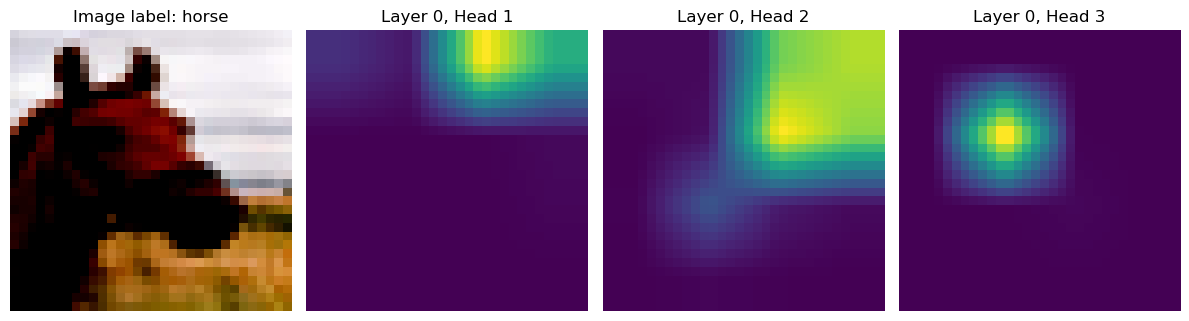

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


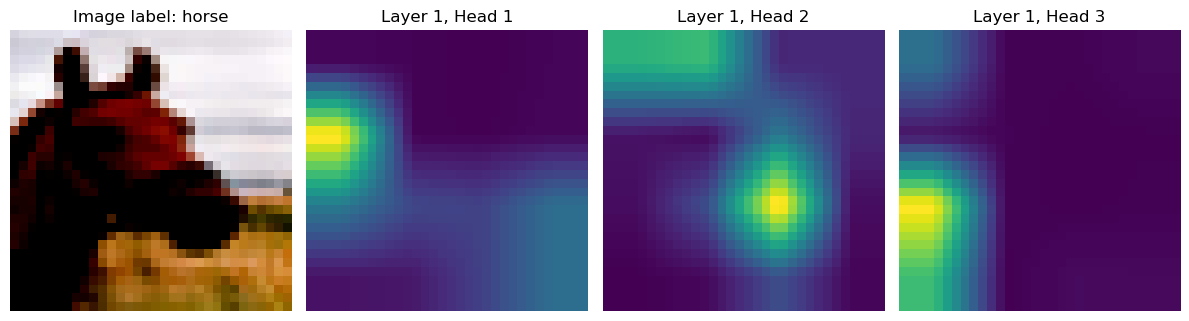

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


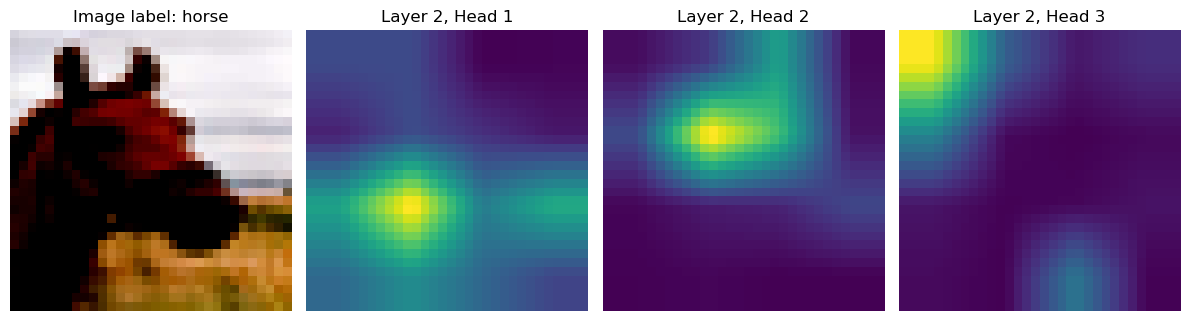

In [36]:
visualization(99, m2, 0)
visualization(99, m2, 1)
visualization(99, m2, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


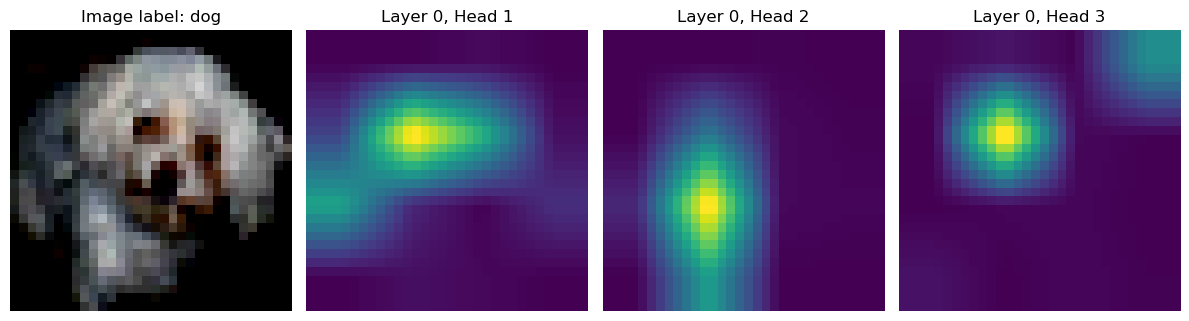

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


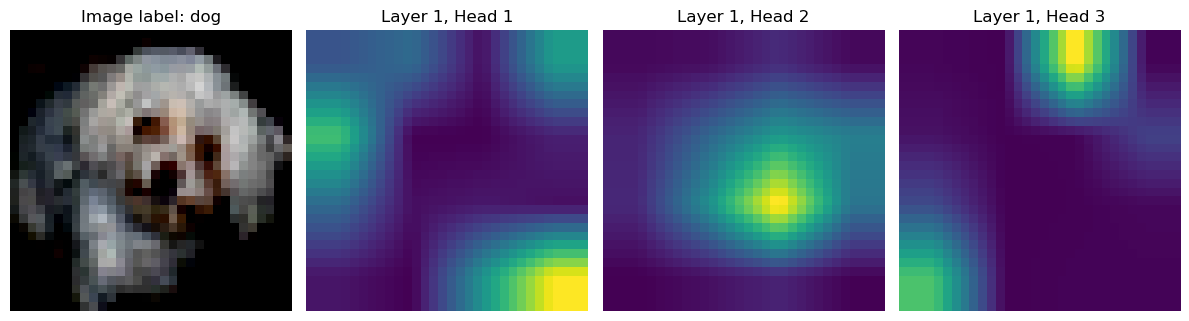

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


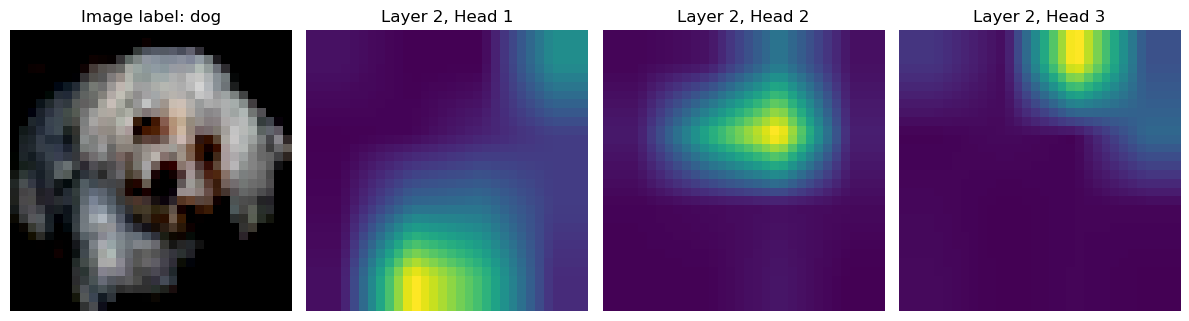

In [38]:
visualization(1000, m2, 0)
visualization(1000, m2, 1)
visualization(1000, m2, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


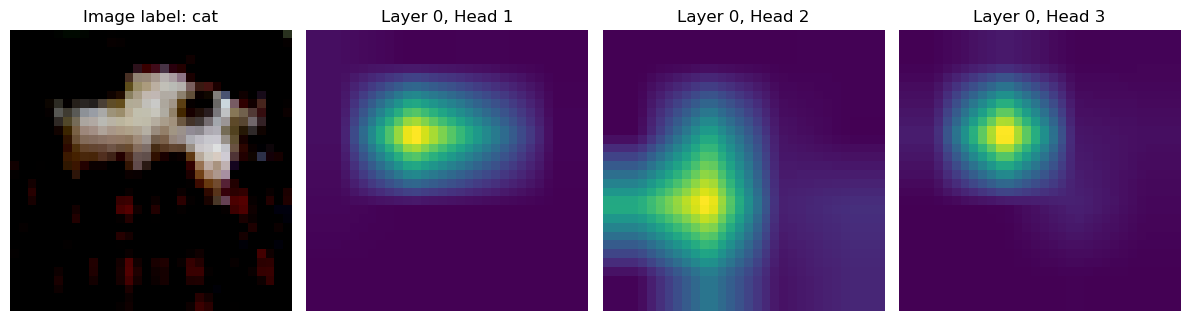

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


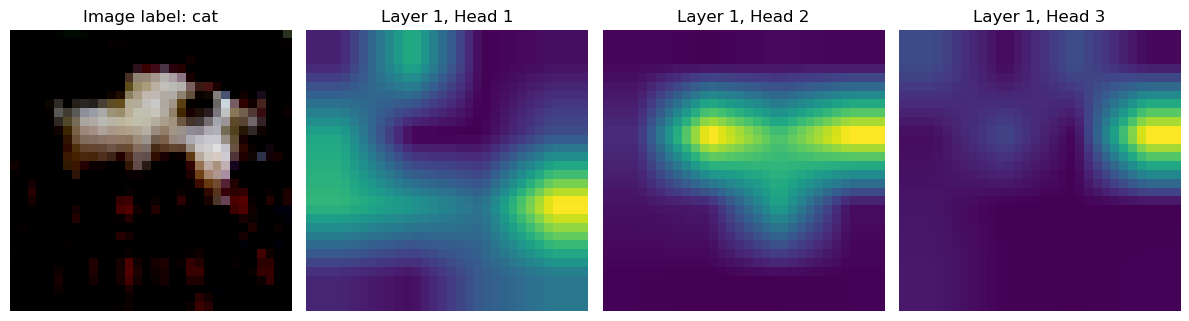

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


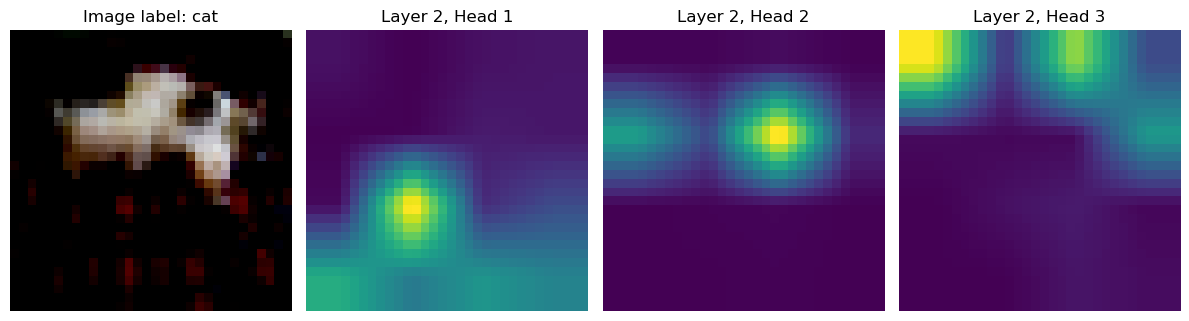

In [51]:
visualization(143, m2, 0)
visualization(143, m2, 1)
visualization(143, m2, 2)

<b>Attention Map Insights</b>

Lower Layers: Attend to local patterns like edges, corners, and textures. These layers extract basic visual features, similar to CNN filters.

Middle Layers: Learn to recognize shapes, object parts, and contours by aggregating local features from earlier layers.

Higher Layers: Focus on long-range dependencies and semantic understanding, enabling classification by relating distant regions in the image.

Different attention heads exhibit distinct behaviors—some focus on textures, others on object boundaries or spatial structure.


In [43]:
m3 = Transformer(3, 3, 32, 32, 4, 72, 10).to(device) #patch size 4

In [50]:
optimizer = torch.optim.Adam(m3.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
train(m3, trainload, criterion, optimizer, epochs=50)

Epoch [1/50], Loss: 1.9122, Acc: 0.3028
Epoch [2/50], Loss: 1.6406, Acc: 0.4103
Epoch [3/50], Loss: 1.5301, Acc: 0.4536
Epoch [4/50], Loss: 1.4589, Acc: 0.4770
Epoch [5/50], Loss: 1.4056, Acc: 0.4947
Epoch [6/50], Loss: 1.3662, Acc: 0.5091
Epoch [7/50], Loss: 1.3286, Acc: 0.5214
Epoch [8/50], Loss: 1.2957, Acc: 0.5331
Epoch [9/50], Loss: 1.2689, Acc: 0.5415
Epoch [10/50], Loss: 1.2450, Acc: 0.5493
Epoch [11/50], Loss: 1.2247, Acc: 0.5587
Epoch [12/50], Loss: 1.2036, Acc: 0.5660
Epoch [13/50], Loss: 1.1796, Acc: 0.5739
Epoch [14/50], Loss: 1.1605, Acc: 0.5832
Epoch [15/50], Loss: 1.1467, Acc: 0.5868
Epoch [16/50], Loss: 1.1304, Acc: 0.5937
Epoch [17/50], Loss: 1.1141, Acc: 0.5994
Epoch [18/50], Loss: 1.0995, Acc: 0.6048
Epoch [19/50], Loss: 1.0862, Acc: 0.6112
Epoch [20/50], Loss: 1.0699, Acc: 0.6168
Epoch [21/50], Loss: 1.0570, Acc: 0.6208
Epoch [22/50], Loss: 1.0410, Acc: 0.6251
Epoch [23/50], Loss: 1.0270, Acc: 0.6303
Epoch [24/50], Loss: 1.0175, Acc: 0.6339
Epoch [25/50], Loss: 1.00

In [51]:
evaluate(m3,testload)

Test Accuracy: 0.6061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


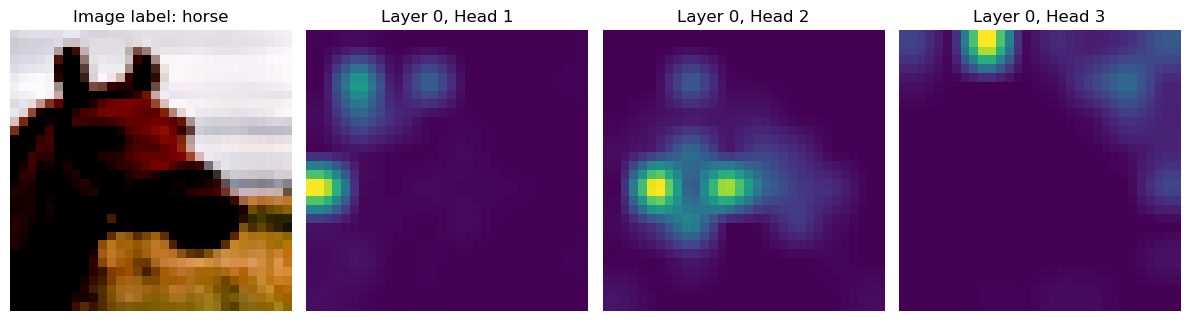

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


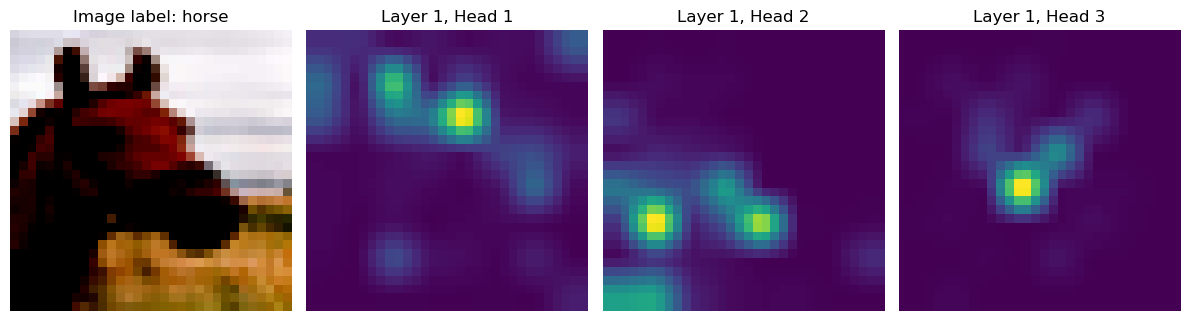

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


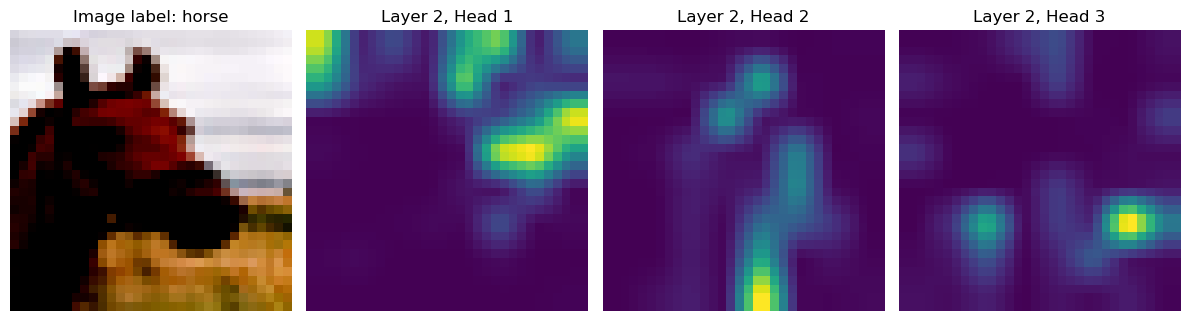

In [ ]:
visualization(99, m3, 0)
visualization(99, m3, 1)
visualization(99, m3, 2)

In [54]:
m4 = Transformer(6, 3, 32, 32, 8, 72, 10).to(device) #layer 6

In [55]:
optimizer = torch.optim.Adam(m4.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
train(m4, trainload, criterion, optimizer, epochs=50)

Epoch [1/50], Loss: 1.8555, Acc: 0.3216
Epoch [2/50], Loss: 1.5341, Acc: 0.4508
Epoch [3/50], Loss: 1.4155, Acc: 0.4915
Epoch [4/50], Loss: 1.3430, Acc: 0.5188
Epoch [5/50], Loss: 1.2867, Acc: 0.5373
Epoch [6/50], Loss: 1.2422, Acc: 0.5544
Epoch [7/50], Loss: 1.2042, Acc: 0.5723
Epoch [8/50], Loss: 1.1734, Acc: 0.5807
Epoch [9/50], Loss: 1.1394, Acc: 0.5939
Epoch [10/50], Loss: 1.1123, Acc: 0.6029
Epoch [11/50], Loss: 1.0831, Acc: 0.6132
Epoch [12/50], Loss: 1.0581, Acc: 0.6237
Epoch [13/50], Loss: 1.0342, Acc: 0.6304
Epoch [14/50], Loss: 1.0088, Acc: 0.6404
Epoch [15/50], Loss: 0.9879, Acc: 0.6471
Epoch [16/50], Loss: 0.9618, Acc: 0.6562
Epoch [17/50], Loss: 0.9425, Acc: 0.6643
Epoch [18/50], Loss: 0.9179, Acc: 0.6732
Epoch [19/50], Loss: 0.8950, Acc: 0.6817
Epoch [20/50], Loss: 0.8742, Acc: 0.6889
Epoch [21/50], Loss: 0.8575, Acc: 0.6956
Epoch [22/50], Loss: 0.8372, Acc: 0.7017
Epoch [23/50], Loss: 0.8187, Acc: 0.7096
Epoch [24/50], Loss: 0.7971, Acc: 0.7149
Epoch [25/50], Loss: 0.78

In [56]:
evaluate(m4,testload)

Test Accuracy: 0.5940


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


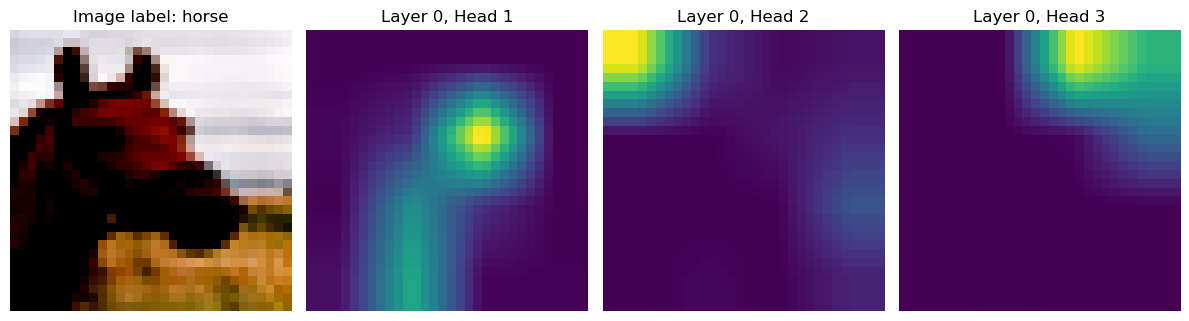

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


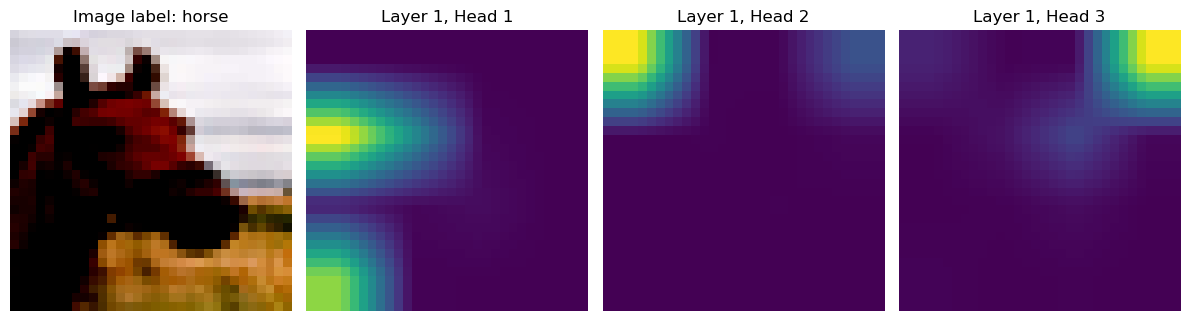

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


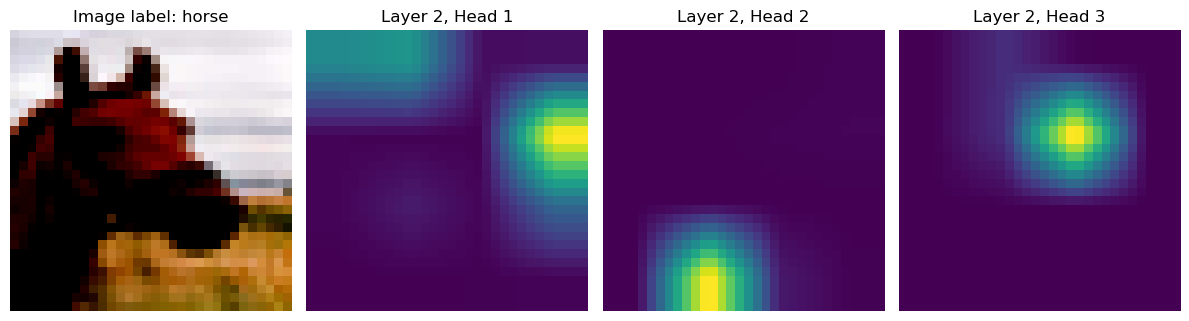

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


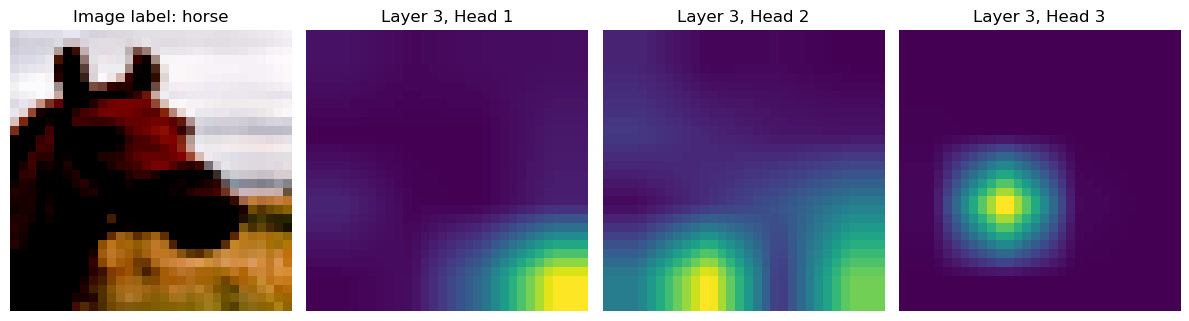

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


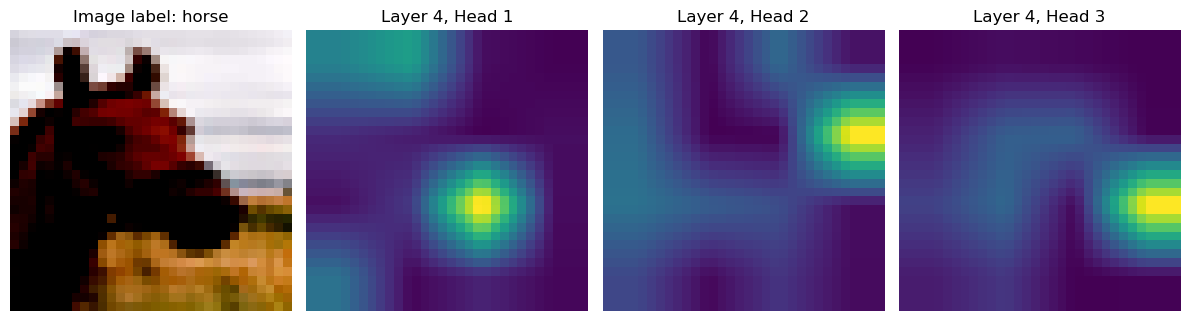

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


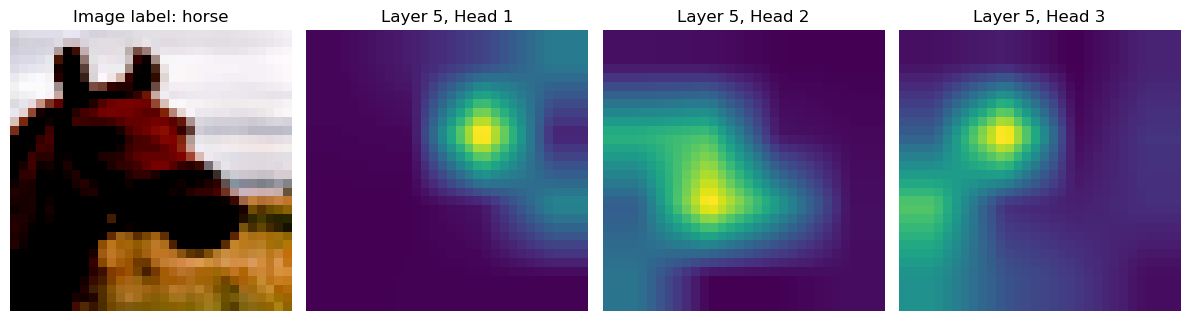

In [89]:
visualization(99, m4, 0)
visualization(99, m4, 1)
visualization(99, m4, 2)
visualization(99, m4, 3)
visualization(99, m4, 4)
visualization(99, m4, 5)

In [80]:
m5 = Transformer(3, 6, 32, 32, 8, 72, 10).to(device) #heads 6

In [81]:
optimizer = torch.optim.Adam(m5.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
train(m5, trainload, criterion, optimizer, epochs=50)

Epoch [1/50], Loss: 1.8821, Acc: 0.3147
Epoch [2/50], Loss: 1.5763, Acc: 0.4325
Epoch [3/50], Loss: 1.4680, Acc: 0.4721
Epoch [4/50], Loss: 1.3974, Acc: 0.4973
Epoch [5/50], Loss: 1.3421, Acc: 0.5152
Epoch [6/50], Loss: 1.2990, Acc: 0.5300
Epoch [7/50], Loss: 1.2626, Acc: 0.5435
Epoch [8/50], Loss: 1.2312, Acc: 0.5570
Epoch [9/50], Loss: 1.2057, Acc: 0.5672
Epoch [10/50], Loss: 1.1812, Acc: 0.5747
Epoch [11/50], Loss: 1.1573, Acc: 0.5847
Epoch [12/50], Loss: 1.1375, Acc: 0.5925
Epoch [13/50], Loss: 1.1162, Acc: 0.5987
Epoch [14/50], Loss: 1.0967, Acc: 0.6058
Epoch [15/50], Loss: 1.0836, Acc: 0.6113
Epoch [16/50], Loss: 1.0613, Acc: 0.6194
Epoch [17/50], Loss: 1.0470, Acc: 0.6234
Epoch [18/50], Loss: 1.0306, Acc: 0.6304
Epoch [19/50], Loss: 1.0149, Acc: 0.6368
Epoch [20/50], Loss: 0.9964, Acc: 0.6447
Epoch [21/50], Loss: 0.9823, Acc: 0.6490
Epoch [22/50], Loss: 0.9703, Acc: 0.6536
Epoch [23/50], Loss: 0.9550, Acc: 0.6598
Epoch [24/50], Loss: 0.9398, Acc: 0.6643
Epoch [25/50], Loss: 0.92

In [82]:
evaluate(m5,testload)

Test Accuracy: 0.5886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


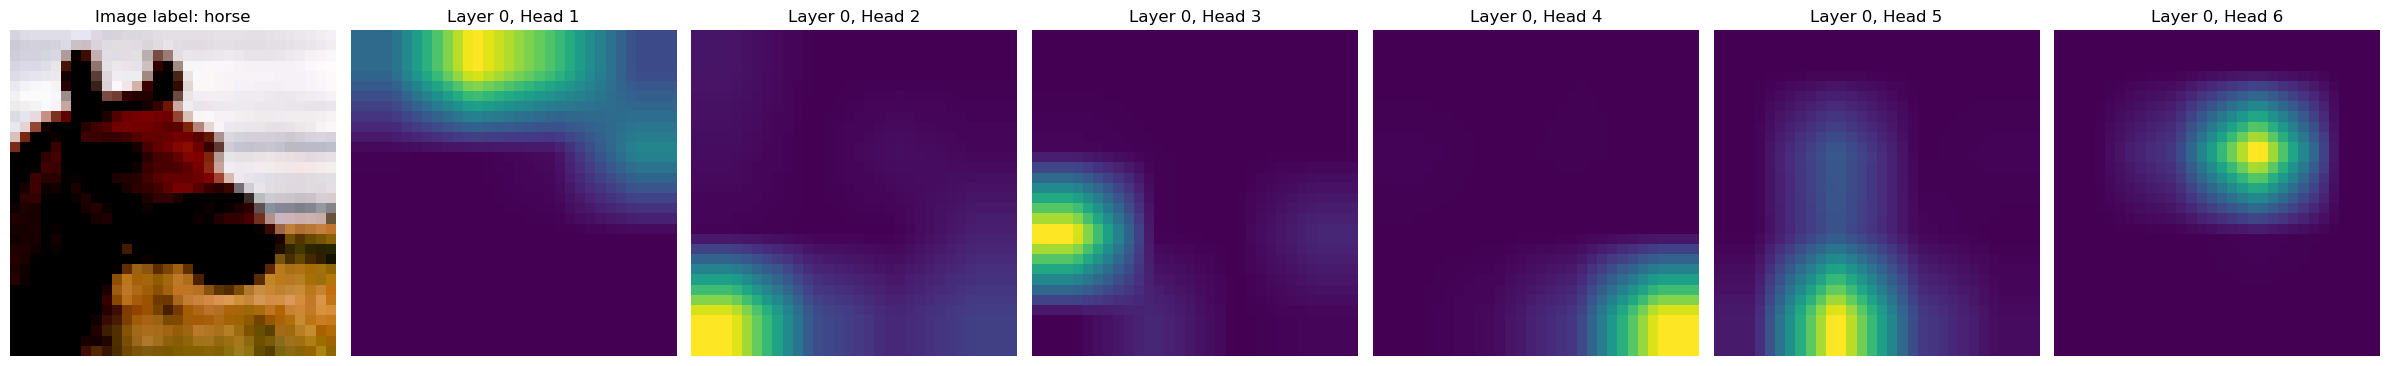

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


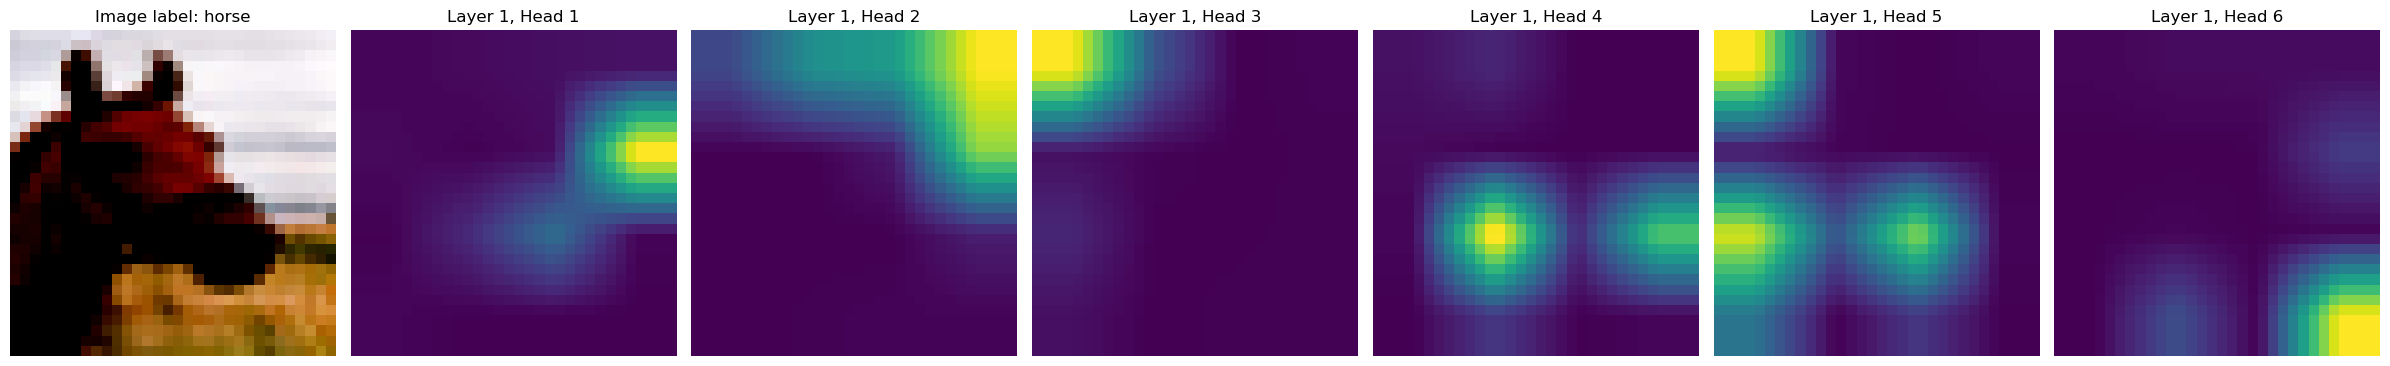

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


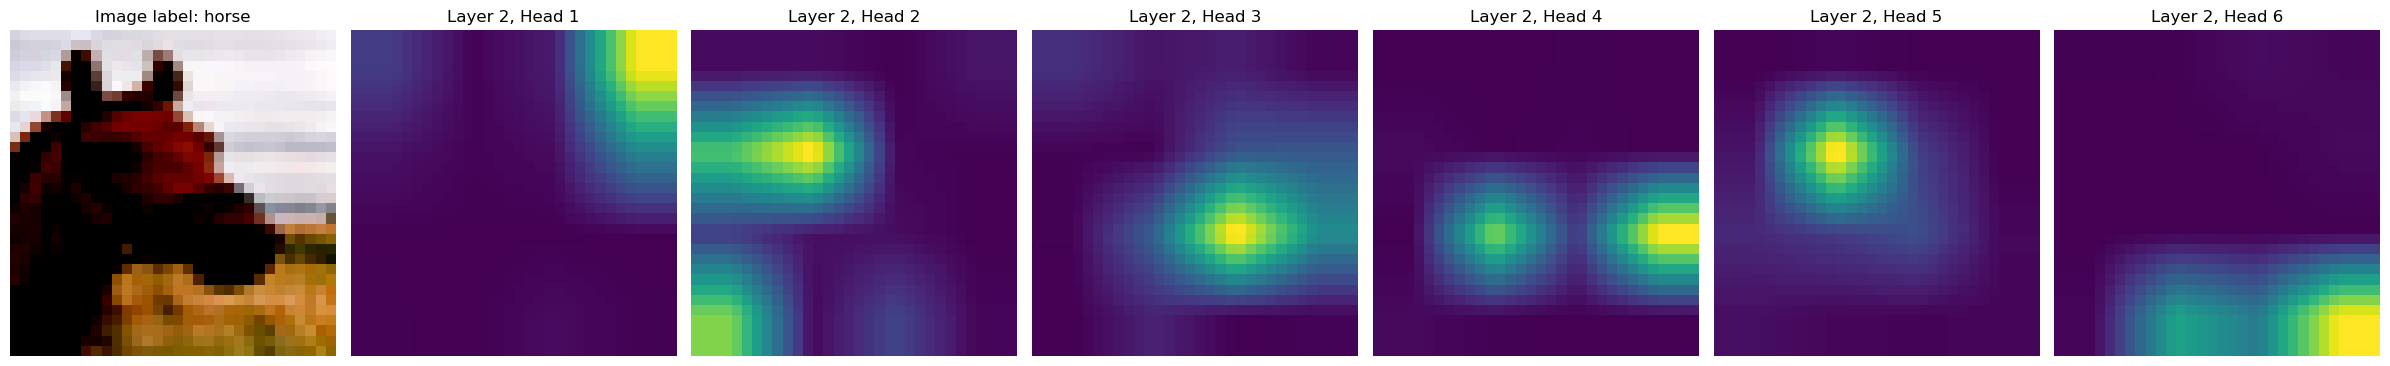

In [ ]:
visualization(99, m5, 0, nhds=6)
visualization(99, m5, 1, nhds=6)
visualization(99, m5, 2, nhds=6)

<b>Hyperparameter Impact</b>

Layers:
More layers improve hierarchical feature extraction but increase overfitting risk and computation time.
Too few layers lead to limited learning capacity.

model m4(6 layers) performs better than m2(3 layers)

Patch Size:
Smaller patches preserve fine details but increase computational cost.
Larger patches improve global understanding but may miss finer structures.
Optimal patch size balances local and global information.

model m2(8x8 size) performs better then m3(4x4 size).

Heads:
More heads allow diverse attention patterns, improving feature richness.
Excessive heads lead to redundancy and unnecessary computational cost.
model

model m5(6 heads) extracts more features than m2(3 heads)
